In [1]:
# Install Kaggle API
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()  # Manually upload kaggle.json here

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
# Download the dataset (replace with actual dataset name)
!kaggle datasets download -d dagnelies/deepfake-faces --unzip


Dataset URL: https://www.kaggle.com/datasets/dagnelies/deepfake-faces
License(s): other


In [3]:
import os
os.listdir()


['.config', 'metadata.csv', 'faces_224', 'sample_data']

In [4]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [5]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [6]:
meta = pd.read_csv('metadata.csv')
meta

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4
...,...,...,...,...,...
95629,rqcsjlsmiz.mp4,129,129,FAKE,pbsccacgff.mp4
95630,xjmnerypjf.mp4,90,90,FAKE,qrjydgidga.mp4
95631,hnewpzhihy.mp4,75,75,FAKE,vabhbfiifl.mp4
95632,okbarlnmwm.mp4,268,267,FAKE,uqaaspbgtz.mp4


In [7]:
meta.shape

(95634, 5)

In [8]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

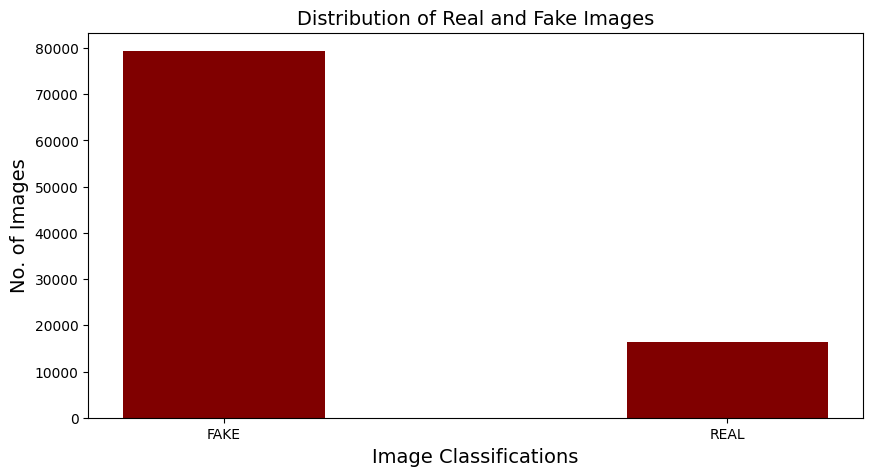

In [9]:
fig = plt.figure(figsize = (10, 5))

plt.bar(list(meta['label'].unique()), list(meta['label'].value_counts().values), color ='maroon', width = 0.4)

plt.xlabel("Image Classifications")
plt.ylabel("No. of Images")
plt.title("Distribution of Real and Fake Images")
plt.show()

In [10]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [11]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [12]:
Train_set.shape,Val_set.shape,Test_set.shape

((8960, 5), (3840, 5), (3200, 5))

In [13]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

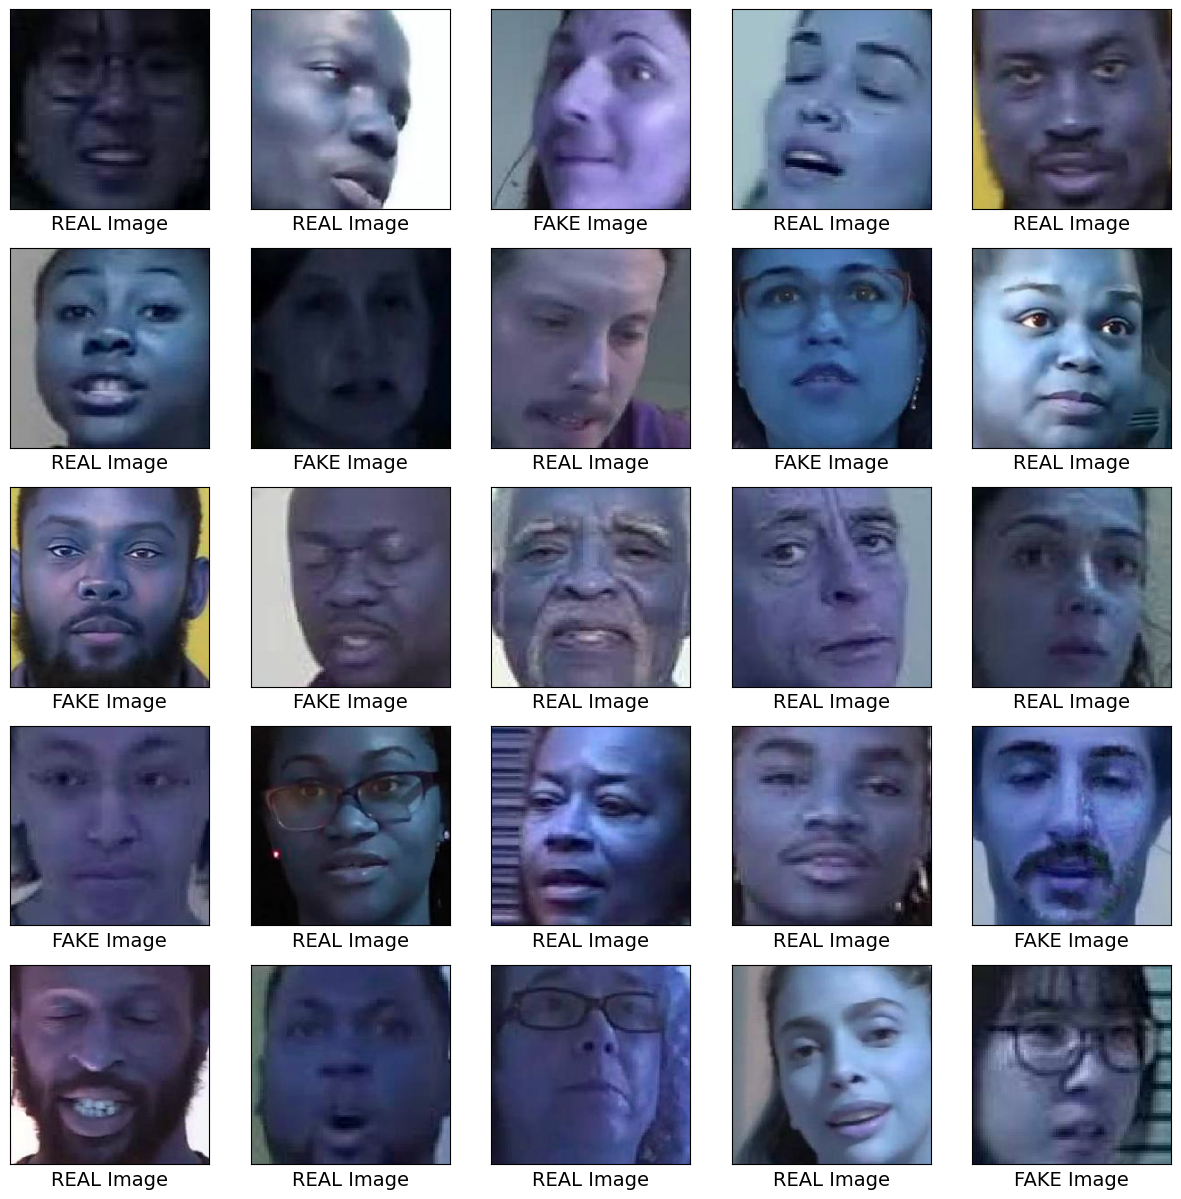

In [14]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(cv2.imread('faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))

    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')

plt.show()

In [15]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)

    return np.array(images),np.array(labels)

In [16]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [17]:
from functools import partial

tf.random.set_seed(42);
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal");

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
]);

In [18]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      51,380,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,619,585 (196.91 MB)

 Trainable params: 51,619,585 (196.91 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val));

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 83s 416ms/step - accuracy: 0.5046 - loss: 636.3179 - val_accuracy: 0.4984 - val_loss: 0.6933
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 301ms/step - accuracy: 0.4897 - loss: 0.6936 - val_accuracy: 0.4992 - val_loss: 0.6932
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 301ms/step - accuracy: 0.5054 - loss: 0.6928 - val_accuracy: 0.5003 - val_loss: 0.6935
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 302ms/step - accuracy: 0.5061 - loss: 0.6929 - val_accuracy: 0.5018 - val_loss: 0.6939
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 302ms/step - accuracy: 0.4924 - loss: 0.6929 - val_accuracy: 0.5029 - val_loss: 0.6924


In [20]:
score = model.evaluate(X_test, y_test);
score

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4879 - loss: 0.6929


[0.6936709880828857, 0.49937498569488525]

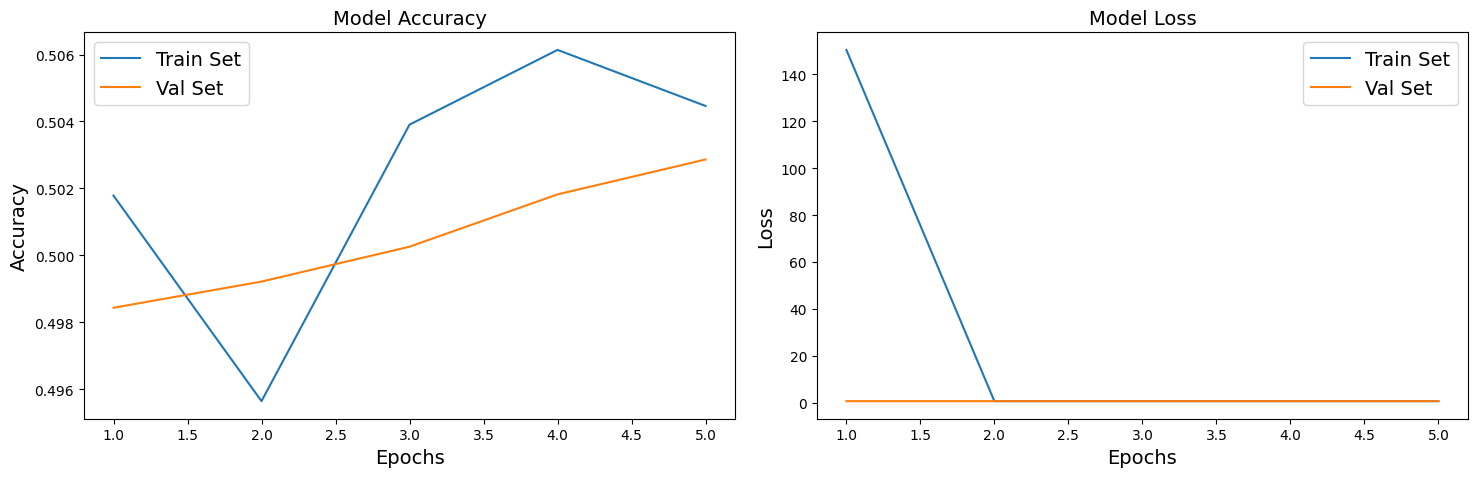

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [22]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [23]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

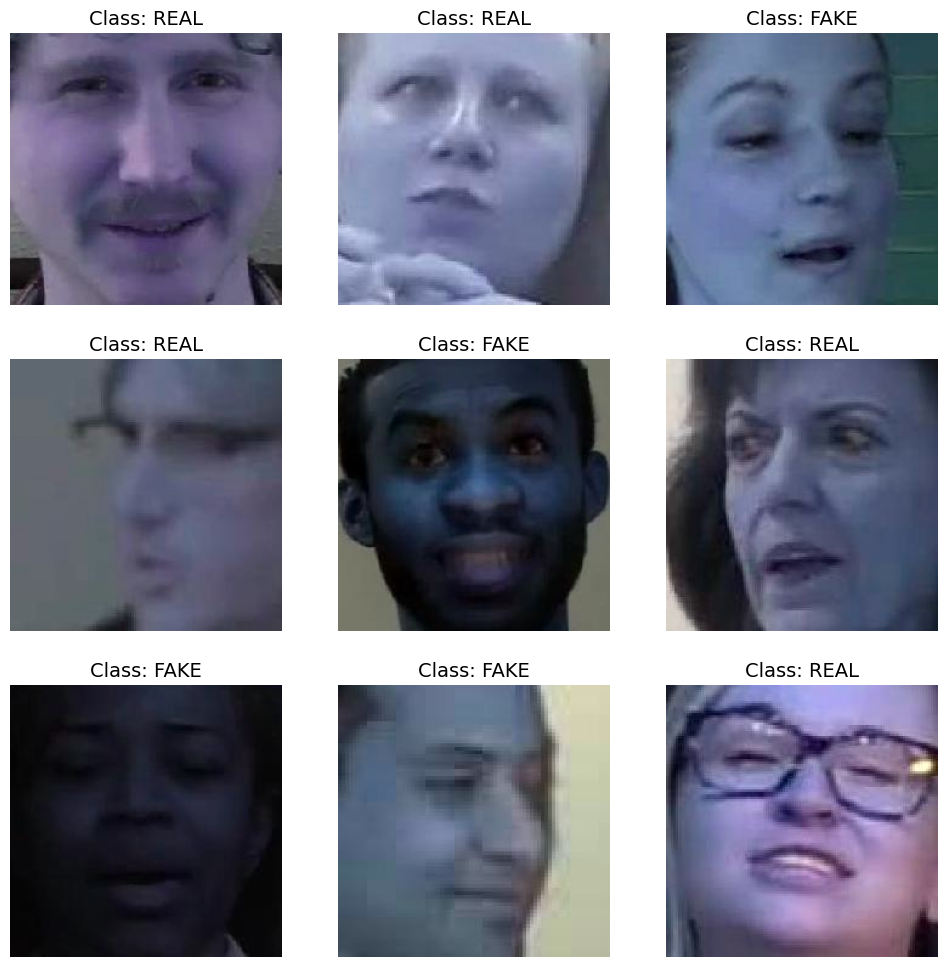

In [24]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [25]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
#     tf.keras.layers.RandomRotation(factor=0.05, seed=42),
#     tf.keras.layers.RandomContrast(factor=0.2, seed=42)
# ])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.1, seed=42),  # Increased rotation
    tf.keras.layers.RandomContrast(factor=0.3, seed=42),  # Stronger contrast
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, seed=42),  # New zoom
    tf.keras.layers.GaussianNoise(0.1)  # New noise layer
])


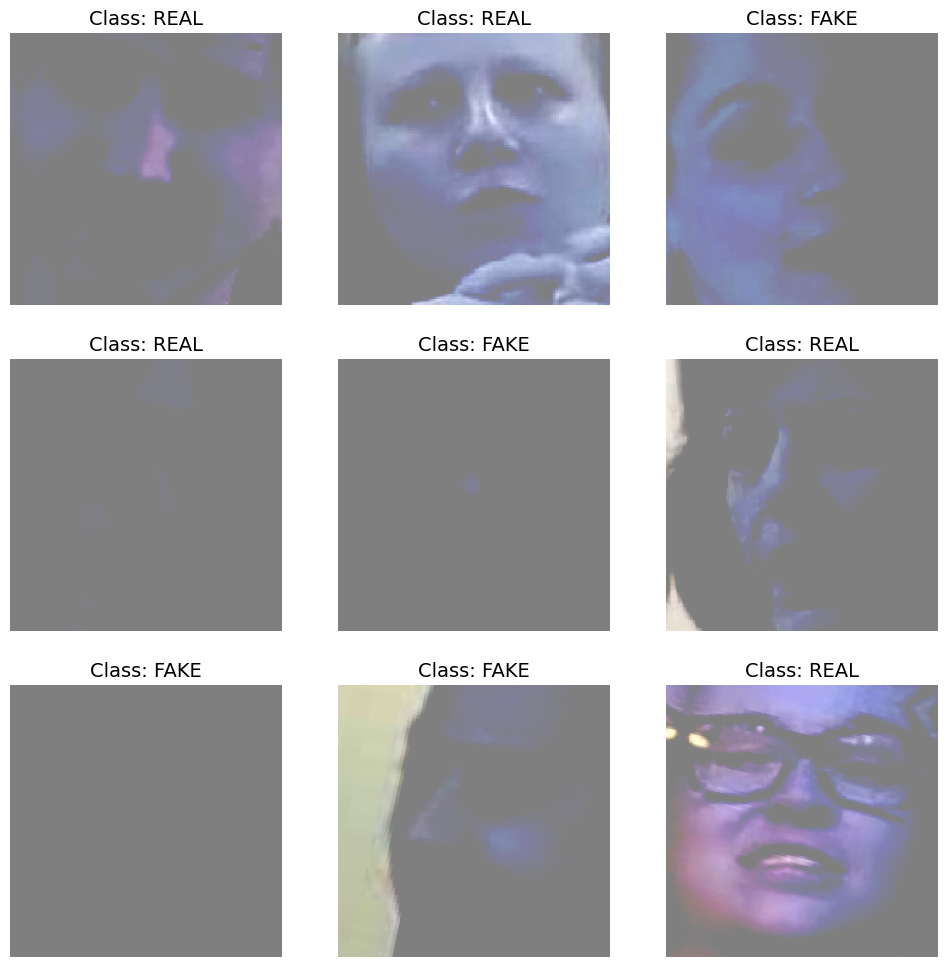

In [26]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [27]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [28]:
for layer in base_model.layers:
    layer.trainable = False

In [29]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 67s 194ms/step - accuracy: 0.5671 - loss: 0.9038 - val_accuracy: 0.5656 - val_loss: 1.4633
Epoch 2/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 57s 200ms/step - accuracy: 0.6122 - loss: 0.8887 - val_accuracy: 0.6185 - val_loss: 0.8424
Epoch 3/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 77s 183ms/step - accuracy: 0.6362 - loss: 0.8633 - val_accuracy: 0.6289 - val_loss: 0.8517


In [30]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_1          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [31]:
model.evaluate(test_set)

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6293 - loss: 0.8571


[0.8790528774261475, 0.6168749928474426]

In [32]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 120s 353ms/step - accuracy: 0.5297 - loss: 0.7290 - val_accuracy: 0.6943 - val_loss: 0.6202
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 98s 349ms/step - accuracy: 0.7503 - loss: 0.5147 - val_accuracy: 0.7672 - val_loss: 0.4811
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 142s 349ms/step - accuracy: 0.9013 - loss: 0.2288 - val_accuracy: 0.7688 - val_loss: 0.5924
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 98s 349ms/step - accuracy: 0.9517 - loss: 0.1274 - val_accuracy: 0.7576 - val_loss: 0.7622
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 98s 348ms/step - accuracy: 0.9648 - loss: 0.0996 - val_accuracy: 0.7727 - val_loss: 0.6612
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 92s 327ms/step - accuracy: 0.9757 - loss: 0.0654 - val_accuracy: 0.8117 - val_loss: 0.7537
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 98s 348ms/step - accuracy: 0.9808 - loss: 0.0546 - val_accuracy: 0.7979 - val_loss: 0.7155
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 142s 348ms/step - accuracy: 0.9822 - loss

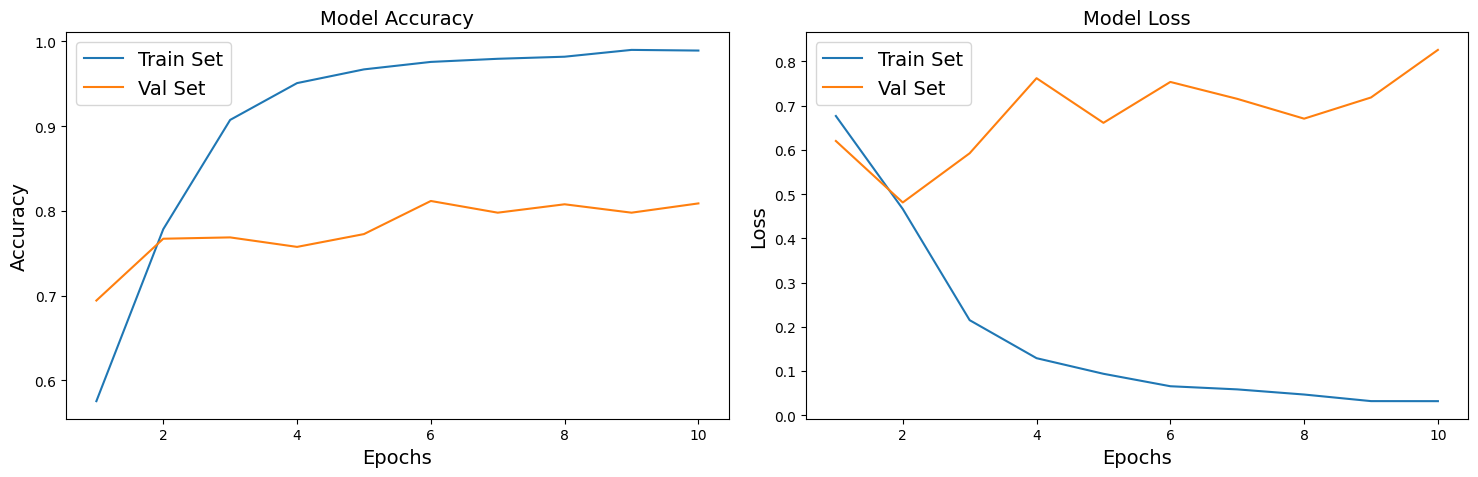

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [34]:
model.evaluate(test_set)

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.8136 - loss: 0.7814


[0.7573921084403992, 0.8137500286102295]

In [35]:
model.save('xception_deepfake_image.h5')

In [38]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('xception_deepfake_image.h5')

# Print model summary to verify
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 32) │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, None, None, 32) │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, None, None, 32) │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, None, None, 64) │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, None, None, 64) │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, None, None,     │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, None, None,     │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, None, None,     │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, None, None,     │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, None, None,     │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None,     │          8,192 │ block1_conv2_act[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)       

 Total params: 20,863,531 (79.59 MB)

 Trainable params: 16,474,289 (62.84 MB)

 Non-trainable params: 4,389,240 (16.74 MB)

 Optimizer params: 2 (12.00 B)

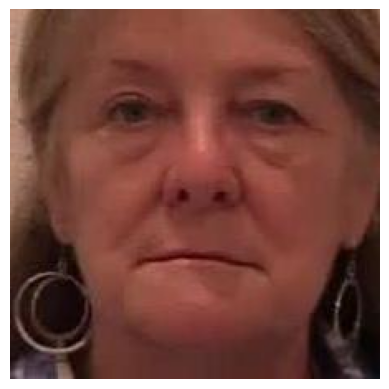

In [43]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Set the image path (replace with an actual filename from your dataset)
image_path = 'faces_224/azcdenjart.jpg'  # Change this to a real image file

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to model's input size
img_array = image.img_to_array(img)  # Convert to NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize (if needed)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


In [44]:
# Get the prediction
prediction = model.predict(img_array)

# Print the result
print("Prediction:", prediction)

# Interpret the result (assuming 0 = Real, 1 = Deepfake)
if prediction[0][0] > 0.5:
    print("The image is a DEEPFAKE")
else:
    print("The image is REAL")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction: [[3.346923e-05]]
The image is REAL


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


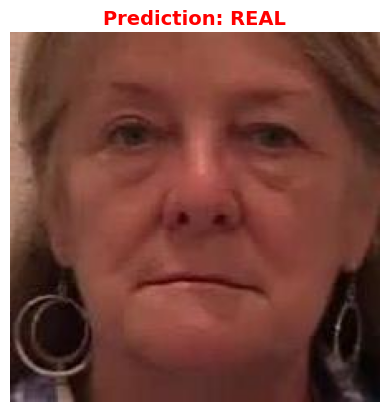

In [45]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Set the image path (replace with an actual filename)
image_path = 'faces_224/azcdenjart.jpg'  # Change this to a real image file

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to model's input size
img_array = image.img_to_array(img)  # Convert to NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize

# Make prediction
prediction = model.predict(img_array)
pred_label = "DEEPFAKE" if prediction[0][0] > 0.5 else "REAL"

# Display image with prediction text
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title(f"Prediction: {pred_label}", fontsize=14, fontweight="bold", color="red")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


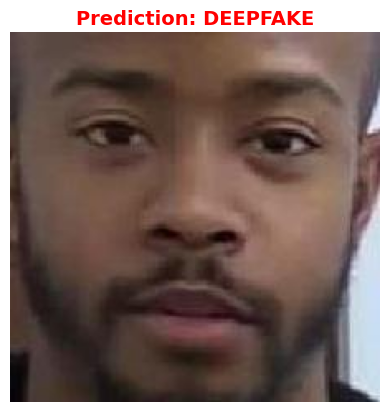

In [46]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Set the image path (replace with an actual filename)
image_path = 'faces_224/azfdkjyiwz.jpg'  # Change this to a real image file

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to model's input size
img_array = image.img_to_array(img)  # Convert to NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize

# Make prediction
prediction = model.predict(img_array)
pred_label = "DEEPFAKE" if prediction[0][0] > 0.5 else "REAL"

# Display image with prediction text
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title(f"Prediction: {pred_label}", fontsize=14, fontweight="bold", color="red")
plt.show()


In [ ]:
from google.colab import files

# Upload a file from your computer
uploaded = files.upload()
